<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

### Import the packages

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

### Data import 

In [128]:
bankloans= pd.read_csv(r"F:\AnalyticslabFIles\class files\Machine learning\Python April BLR _ Class 20 Python for Data Science (Self-paced) v5\Python April BLR _ Class 20 Python for Data Science April 2022 - 1659608821238\bankloans - 1656936041780.csv")

### UDFs

In [129]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [130]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [131]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

### Data inspection

In [45]:
# Check the metadata.
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [46]:
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [47]:
bankloans.default.value_counts()/bankloans.default.notna().sum()

0.0    0.738571
1.0    0.261429
Name: default, dtype: float64

### Separate out the data for existing and new customers.

In [48]:
bankloans.loc[bankloans.default.notna(), :]

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
695,36,2,6,15,27,4.6,0.262062,0.979938,1.0
696,29,2,6,4,21,11.5,0.369495,2.045505,0.0
697,33,1,15,3,32,7.6,0.491264,1.940736,0.0
698,45,1,19,22,77,8.4,2.302608,4.165392,0.0


In [49]:
# Seperate the new and existing customers.
bankloans_existing= bankloans.loc[bankloans.default.notna(), :]
bankloans_new= bankloans.loc[bankloans.default.isna(), :]

In [50]:
bankloans_existing.shape

(700, 9)

In [51]:
# EDA for all the variables
bankloans_existing.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,32,31,114,231,695,699,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0,0,0,0,0,0,0,0,0
sum,24402,1206,5872,5795,31921,7182.4,1087.49,2140.75,183
mean,34.86,1.72286,8.38857,8.27857,45.6014,10.2606,1.55355,3.05821,0.261429
std,7.99734,0.928206,6.65804,6.82488,36.8142,6.82723,2.1172,3.28755,0.439727
var,63.9575,0.861566,44.3295,46.5789,1355.29,46.6111,4.48252,10.808,0.19336


### Data prepration/ Data cleaning

In [52]:
# outlier treatment. 
bankloans_existing= bankloans_existing.apply(lambda x: x.clip(lower= x.quantile(0.01), upper= x.quantile(0.99)))

In [53]:
# Handling missings.
# bankloans_existing= bankloans_existing.apply(lambda x: missing_imputation(x))

### Bi variate analysis to identify correlation.

In [54]:
# Correlation matrix
corr_matrix= bankloans_existing.corr()
# corr_matrix.to_csv('corr.csv')

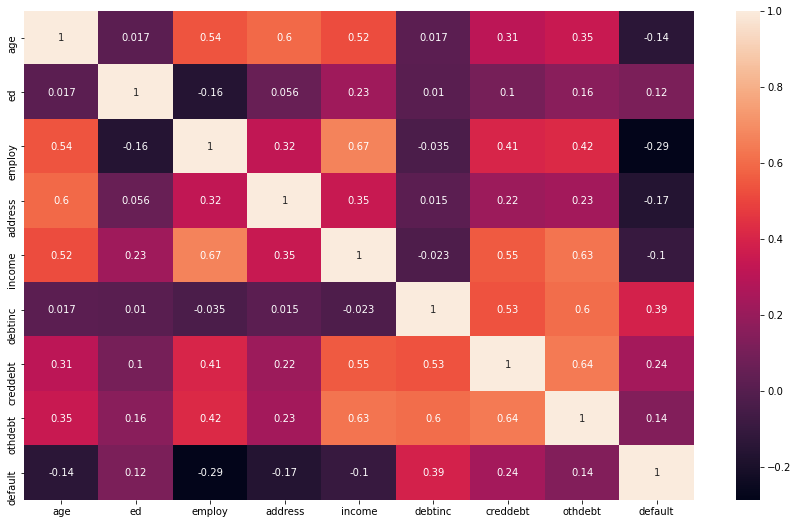

In [55]:
# Visualise correlation matrix in Seaborn using a heatmap
plt.figure(figsize= (15, 9))
sns.heatmap(corr_matrix, annot= True)
plt.show()

### Building Logistic regression model

In [56]:
# Train and Test split
train, test = train_test_split(bankloans_existing, test_size= .3, random_state= 42)

In [57]:
# Print the columns.
train.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [58]:
model_eq= 'default ~ ' + ' + '.join(train.columns.difference(['default']))
model_eq

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [59]:
# Execute a model for X variables.
m1= smf.logit(formula= model_eq, data= train).fit()

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


In [60]:
# Print the model summary stats.
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.275     
Dependent Variable: default          AIC:              434.8834  
Date:               2023-08-03 15:15 BIC:              472.6330  
No. Observations:   490              Log-Likelihood:   -208.44   
Df Model:           8                LL-Null:          -287.47   
Df Residuals:       481              LLR p-value:      4.0651e-30
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.3844    0.7360  -1.8808  0.0600  -2.8270   0.0582
address       -0.0853    0.0258  -3.3063  0.0009  -0.1359  -0.0348
age            0.0389    0.0202   1.9237  0.0544  -0.0007   0.0784
creddebt       0.6410    0.138

### Data Exploratory Analysis
    - Variable Reduction using Somer's D values
    - Bi-variate analysis technique to check the predictive power of each independent against dependent
    - cutoff is 0.2 or 20% below which the variable is insignificant

### Get the Somer's D values for all the X variables.

In [68]:
# Empty dataframe to store information.
df= pd.DataFrame()

# Iterate on each X variable
for var_name in bankloans_existing.columns.difference(['default']):
#     Build the bi_variate model and fit.
    model= smf.logit(formula= 'default ~ ' + var_name, data= bankloans_existing).fit()
    
#     Predict the y
    y_predicted= model.predict(bankloans_existing)
    
#     Get the ruc_auc_score
    ruc_score= roc_auc_score(bankloans_existing.default, y_predicted)
    
#     Get the Somer's D value.
    somers_d= 2 * (ruc_score) - 1
    
#     Store the data in temprary dataset.
    temp_df= pd.DataFrame([var_name, ruc_score, somers_d]).T
    
#     Concat the data with the output dataframe
    df= pd.concat([df, temp_df], axis= 0)
    
# Add the column names.
df.columns= ['Features', 'RUC_AUC_score', "Somer's D" ]

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [69]:
df

,Features,RUC_AUC_score,Somer's D
0,address,0.611192,0.222384
0,age,0.603165,0.206329
0,creddebt,0.636189,0.272378
0,debtinc,0.735253,0.470506
0,ed,0.574151,0.148302
0,employ,0.704569,0.409138
0,income,0.600136,0.200273
0,othdebt,0.586903,0.173806


In [71]:
features= list(df.loc[df["Somer's D"] >= 0.2, 'Features'])

In [72]:
features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

### VIF - Variance Inflation Factor

In [75]:
# run the dmatrices
equation= 'default ~ ' + ' + '.join(features)

a, b= dmatrices(equation, bankloans_existing, return_type= 'dataframe')

# Get the VIF
vif= pd.DataFrame()
vif['features']= b.columns
vif['VIF factor']= [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]

vif

,features,VIF factor
0,Intercept,28.286222
1,address,1.559236
2,age,2.036933
3,creddebt,2.564921
4,debtinc,1.778339
5,employ,1.997947
6,income,2.601717


### Build the actual model

In [76]:
features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

In [77]:
model_eq= 'default ~ ' + ' + '.join(features)
m2= smf.logit(formula= model_eq, data= train).fit()
print(m2.summary2())

Optimization terminated successfully.
         Current function value: 0.426980
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              432.4402  
Date:               2023-08-03 15:44 BIC:              461.8010  
No. Observations:   490              Log-Likelihood:   -209.22   
Df Model:           6                LL-Null:          -287.47   
Df Residuals:       483              LLR p-value:      3.2536e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7966    0.5987  -3.0008  0.0027  -2.9701  -0.6232
address       -0.0849    0.0257  -3.3082  0.0009  -0.1351  -0.

In [78]:
features= ['address', 'age', 'creddebt', 'debtinc', 'employ']

In [79]:
model_eq= 'default ~ ' + ' + '.join(features)
m3= smf.logit(formula= model_eq, data= train).fit()
print(m3.summary2())

Optimization terminated successfully.
         Current function value: 0.427051
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              430.5102  
Date:               2023-08-03 15:45 BIC:              455.6766  
No. Observations:   490              Log-Likelihood:   -209.26   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      5.6901e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7615    0.5836  -3.0185  0.0025  -2.9053  -0.6177
address       -0.0839    0.0254  -3.3047  0.0010  -0.1336  -0.

### Predict  the values

In [80]:
# Predict the values on training and testing.
train_predict= m3.predict(train)
test_predict= m3.predict(test)

In [82]:
train_predict.head(2)

357    0.585803
649    0.529728
dtype: float64

### Model scoring

In [85]:
# Combine the y actual and y predicted
train_data= pd.concat([train.default, train_predict], axis= 1)
test_data= pd.concat([test.default, test_predict], axis= 1)

train_data.columns= ['y_actual', 'y_predict_proba']
test_data.columns= ['y_actual', 'y_predict_proba']

In [87]:
# ruc_auc_score
concordance_train= roc_auc_score(train_data.y_actual, train_data.y_predict_proba)
concordance_test= roc_auc_score(test_data.y_actual, test_data.y_predict_proba)

print('Train:', concordance_train, '| Test:', concordance_test)

Train: 0.838210632232098 | Test: 0.8885790340981113


### Find the model accuracy at cut off 0.5

In [88]:
train_data['y_pred'] = np.where(train_data.y_predict_proba >= 0.5, 1, 0)

In [90]:
# Confusion matrix - Method 1
pd.crosstab(index= train_data.y_actual, columns= train_data.y_pred).loc[::-1, ::-1]

y_pred,1,0
y_actual,,
1.0,63,71
0.0,30,326


In [97]:
# Confusion matrix - Method 2
cm_p50= confusion_matrix(train_data.y_actual, train_data.y_pred)[::-1, ::-1]

tp= cm_p50[0, 0]
tn= cm_p50[1, 1]
fp= cm_p50[1, 0]
fn= cm_p50[0, 1]

accuracy= (tp + tn)/cm_p50.sum()
tpr= tp/(tp+fn)
fpr= fp/(fp+tn)

print(cm_p50)
print('accuracy:', accuracy, '| tpr:', tpr, '| fpr:', fpr)

[[ 63  71]
 [ 30 326]]
accuracy: 0.7938775510204081 | tpr: 0.4701492537313433 | fpr: 0.08426966292134831


In [99]:
print(classification_report(train_data.y_actual, train_data.y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       356
         1.0       0.68      0.47      0.56       134

    accuracy                           0.79       490
   macro avg       0.75      0.69      0.71       490
weighted avg       0.78      0.79      0.78       490



### Get the best cut-off

In [102]:
# Empty dataframe to store the information.
cm_scores= pd.DataFrame()

# Run the loop for different prob values.
for prob_value in np.arange(0, 1.01, 0.01):
    
#     Get the y_pred.
    train_data['y_pred']= np.where(train_data.y_predict_proba >= prob_value, 1, 0)
    
#     Get the confusion matrix.
    cm= confusion_matrix(train_data.y_actual, train_data.y_pred)[::-1, ::-1]
    
#     Get the metrics values.
    tp= cm[0, 0]
    tn= cm[1, 1]
    fp= cm[1, 0]
    fn= cm[0, 1]
    
    accuracy= (tp + tn)/cm.sum()
    tpr= tp/ (tp+fn)
    fpr= fp/ (fp+tn)
    s_s= tpr + 1 - fpr
    
#     Store the data in temp dataframe
    temp_df= pd.DataFrame([prob_value, tp, tn, fp, fn, accuracy, tpr, fpr, s_s]).T
    
#     Add the dataframe to final dataframe.
    cm_scores= pd.concat([cm_scores, temp_df])
    
# Add the column names
cm_scores.columns= ['prob_value', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'tpr', 'fpr', 's_s']

# Get the best cut off value.
best_cutoff= cm_scores.loc[cm_scores.s_s ==cm_scores.s_s.max(), 'prob_value'][0]
print('best_cutoff:', best_cutoff)

best_cutoff: 0.34


### Final prediction with the best cutoff

In [105]:
train_data['y_pred'] = np.where(train_data.y_predict_proba >= best_cutoff, 1, 0)
test_data['y_pred']= np.where(test_data.y_predict_proba >= best_cutoff, 1, 0)

### Classification report from the best cutoff

In [107]:
print(classification_report(train_data.y_actual, train_data.y_pred))
print('---------------------------------------------------------------------
      ')
print(classification_report(test_data.y_actual, test_data.y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84       356
         1.0       0.57      0.74      0.64       134

    accuracy                           0.78       490
   macro avg       0.73      0.76      0.74       490
weighted avg       0.80      0.78      0.78       490

----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       161
         1.0       0.60      0.73      0.66        49

    accuracy                           0.82       210
   macro avg       0.76      0.79      0.77       210
weighted avg       0.84      0.82      0.83       210



### Decile analysis

In [111]:
# Decile analysis for validation of models - Business validation
train_data['Deciles']= pd.qcut(train_data.y_predict_proba, 10, labels= False)
test_data['Deciles']= pd.qcut(test_data.y_predict_proba, 10, labels= False)

### Decile Analysis for train data.

In [112]:
train_data.head()

,y_actual,y_predict_proba,y_pred,Deciles
357,1.0,0.585803,1,8
649,0.0,0.529728,1,8
291,0.0,0.060701,0,2
420,1.0,0.599717,1,8
177,0.0,0.130221,0,3


In [119]:
train_deciles= train_data.pivot_table(values= ['y_predict_proba', 'y_actual'], index= 'Deciles', aggfunc= {'y_predict_proba' : ['min', 'max'], 'y_actual' : ['sum', 'count']}).reset_index().sort_values(by= 'Deciles', ascending= False)
test_deciles= test_data.pivot_table(values= ['y_predict_proba', 'y_actual'], index= 'Deciles', aggfunc= {'y_predict_proba': ['min', 'max'], 'y_actual' : ['sum', 'count']}).reset_index().sort_values(by= 'Deciles', ascending= False)

### Predicting new customers (Implementation of Model on new data)

In [120]:
# Predicting new customers good or bad.
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


#### before scoring new customers, you need to process the data using the same steps you followed while building the model

In [122]:
bankloans_new.loc[:, 'prob']= m3.predict(bankloans_new)

C:\Users\HARSH\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [124]:
bankloans_new['default']= np.where(bankloans_new.prob > best_cutoff , 1, 0)

<ipython-input-124-81a6f2fcdcca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new['default']= np.where(bankloans_new.prob > best_cutoff , 1, 0)


In [125]:
bankloans_new.default.value_counts()

0    107
1     43
Name: default, dtype: int64

In [126]:
bankloans_new.sort_values(by= 'prob', ascending= False)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
803,48,1,10,0,70,28.2,10.679340,9.060660,1,0.997485
840,35,2,11,1,62,32.4,9.702504,10.385496,1,0.992220
810,26,4,1,6,64,23.3,7.754240,7.157760,1,0.991865
716,26,4,1,5,92,13.0,6.506240,5.453760,1,0.967938
836,41,2,13,1,93,14.7,9.542358,4.128642,1,0.961655
...,...,...,...,...,...,...,...,...,...,...
728,39,1,19,16,53,3.7,0.190217,1.770783,0,0.002405
742,44,4,18,23,78,1.0,0.564720,0.215280,0,0.002167
749,48,2,21,14,86,1.2,0.145512,0.886488,0,0.001985
723,52,1,33,23,139,5.6,2.288496,5.495504,0,0.000256
